In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline
%load_ext autoreload
%autoreload 2

def plot_points3d(pts, fig=None, label=False, marker_size=3, color="orange", opacity=1.0,
                  x_range=None, y_range=None, z_range=None):

    if label:
        names = [f'{i}' for i in range(len(pts))]
    else:
        names = None
    pts = go.Scatter3d(x=pts[..., 0], y=pts[..., 1], z=pts[..., 2],
                       mode='markers', marker=dict(size=marker_size), text=names,
                       line=dict(color=color), opacity=opacity)


    data = [pts]
    if fig is None:
        fig = go.Figure(data=data)
    else:
        for d in data:
            fig.add_trace(d)
    scene = None
    if x_range is not None:
        scene = dict(
                    aspectmode='cube',
                    xaxis=dict(range=x_range),
                    yaxis=dict(range=y_range),
                    zaxis=dict(range=z_range),
                )
        fig.update_layout(scene=scene)
    return fig


In [2]:
import torch
from zju_smpl.smplmodel.body_model import SMPLlayer

def export_vetices(
    h5_path,
    out_path,   
    smpl_path = 'smpl/',
    gender = 'neutral',
    device = 'cuda',
):
    dataset = h5py.File(h5_path, 'r')
    shapes = dataset['betas'][:]
    poses = dataset['bones'][:]
    Rh = dataset['Rhs'][:]
    Th = dataset['Ths'][:]
    dataset.close()

    # remove root rotation
    poses[:, 0] = 0

    shapes = torch.tensor(shapes).float().to(device)
    poses = torch.tensor(poses).float().to(device)
    Rh = torch.tensor(Rh).float().to(device)
    Th = torch.tensor(Th).float().to(device)

    smpl_layer = SMPLlayer(
        smpl_path,
        gender=gender,
        device=device,
        regressor_path=os.path.join(
            smpl_path,
            'J_regressor_body25.npy'
        )
    ).to(device)

    print(f'{shapes.shape} {poses.shape} {Rh.shape} {Th.shape}')
    new_params = True
    vertices = []
    for i, (s, p, R, T) in enumerate(zip(shapes, poses, Rh, Th)):
        params = {
            'poses': p[None],
            'shapes': s[None],
            'Rh': R[None],
            'Th': T[None],
        }
        vertices.append(smpl_layer(
            return_verts=True,
            new_params=new_params,
            **params
        ))
    vertices = torch.stack(vertices).cpu().numpy()

    np.save(out_path, vertices)
    return vertices



In [44]:

h5_base = 'data/RNA_Real/'
split = 'val'
subject_name = 'Sequence1_smpl-new'

h5_path = os.path.join(h5_base, f'{subject_name}_{split}.h5')
out_path = os.path.join(h5_base, 'vertices', f'{subject_name}_{split}.npy')
os.makedirs(os.path.join(h5_base, 'vertices'), exist_ok=True)

vertices = export_vetices(
    h5_path,
    out_path,
)

split = 'train'
subject_name = 'Sequence1_smpl-new'

h5_path = os.path.join(h5_base, f'{subject_name}_{split}.h5')
out_path = os.path.join(h5_base, 'vertices', f'{subject_name}_{split}.npy')
os.makedirs(os.path.join(h5_base, 'vertices'), exist_ok=True)

vertices = export_vetices(
    h5_path,
    out_path,
)

torch.Size([100, 10]) torch.Size([100, 24, 3]) torch.Size([100, 3]) torch.Size([100, 3])
torch.Size([300, 10]) torch.Size([300, 24, 3]) torch.Size([300, 3]) torch.Size([300, 3])


In [47]:
plot_points3d(vertices[95], marker_size=1, opacity=0.5)

In [3]:
from lib.datasets.light_stage.gscreal_dataset import Dataset

dataset = Dataset(
    'data/RNA_Real/',
    'Sequence1_smpl',
    split='train,'
)

usage: ipykernel_launcher.py [-h] [--cfg_file CFG_FILE] [--test] [--type TYPE]
                             [--det DET] [--local_rank LOCAL_RANK]
                             [--launcher {none,pytorch}] [--dist_url DIST_URL]
                             ...
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"921e6dd6-2258-4d6d-b9b7-38ea91947fbb" --shell=9012 --transport="tcp" --iopub=9014 --f=/ubc/cs/home/s/shihyang/.local/share/jupyter/runtime/kernel-v2-200404y2H8mpo9QFqD.json


SystemExit: 2

In [45]:
h5_file = h5py.File('data/RNA_Real/Sequence1_smpl-new_train.h5', 'r')
imgs = h5_file['imgs'][:].reshape(-1, 1080, 1920, 3)
#sampling_masks = h5_file['sampling_masks'][:].reshape(-1, 1080, 1920, 1)
cam_idxs = h5_file['img_pose_indices'][:]
focals = h5_file['focals'][:][cam_idxs]
centers = h5_file['centers'][:][cam_idxs]
c2ws = h5_file['c2ws'][:][cam_idxs]
kp_idxs = h5_file['kp_idxs'][:]
kp3d = h5_file['kp3d'][:]
print(c2ws.shape)

swap_rot = np.eye(4)[None].astype(np.float32)
swap_rot[:, 1, 1] = -1.
swap_rot[:, 2, 2] = -1.
RT = np.linalg.inv(c2ws @ swap_rot).astype(np.float32)
K = np.eye(3)[None].repeat(len(focals), 0)
K[:, 0, 0] = focals[:, 0]
K[:, 1, 1] = focals[:, 1]

K[:, 0, 2] = centers[:, 0]
K[:, 1, 2] = centers[:, 1]
K = K.astype(np.float32)
h5_file.close()
vertices = np.load('data/RNA_Real/vertices/Sequence1_smpl-new_train.npy')

(900, 4, 4)


In [48]:
from lib.utils.base_utils import project
vertices_2d = []

for v, kp_idx in enumerate(kp_idxs):
    #print(f'{kp_idx} {cam_idxs[v]}')
    xy = project(vertices[kp_idx], K[v], RT[v, :3, :4])
    vertices_2d.append(xy)
vertices_2d = np.stack(vertices_2d)
print(vertices_2d.shape)


(900, 6890, 2)


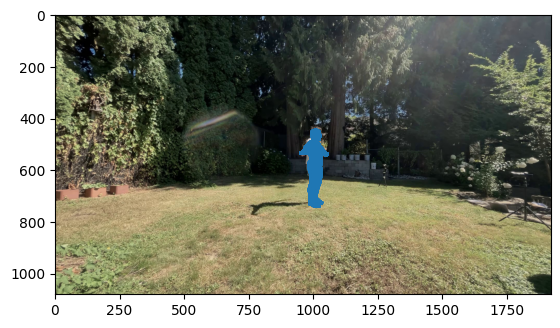

In [50]:
idx = 620
plt.imshow(imgs[idx])
plt.scatter(vertices_2d[idx, :, 0], vertices_2d[idx, :, 1], s=1)

IndexError: index 515 is out of bounds for axis 0 with size 300

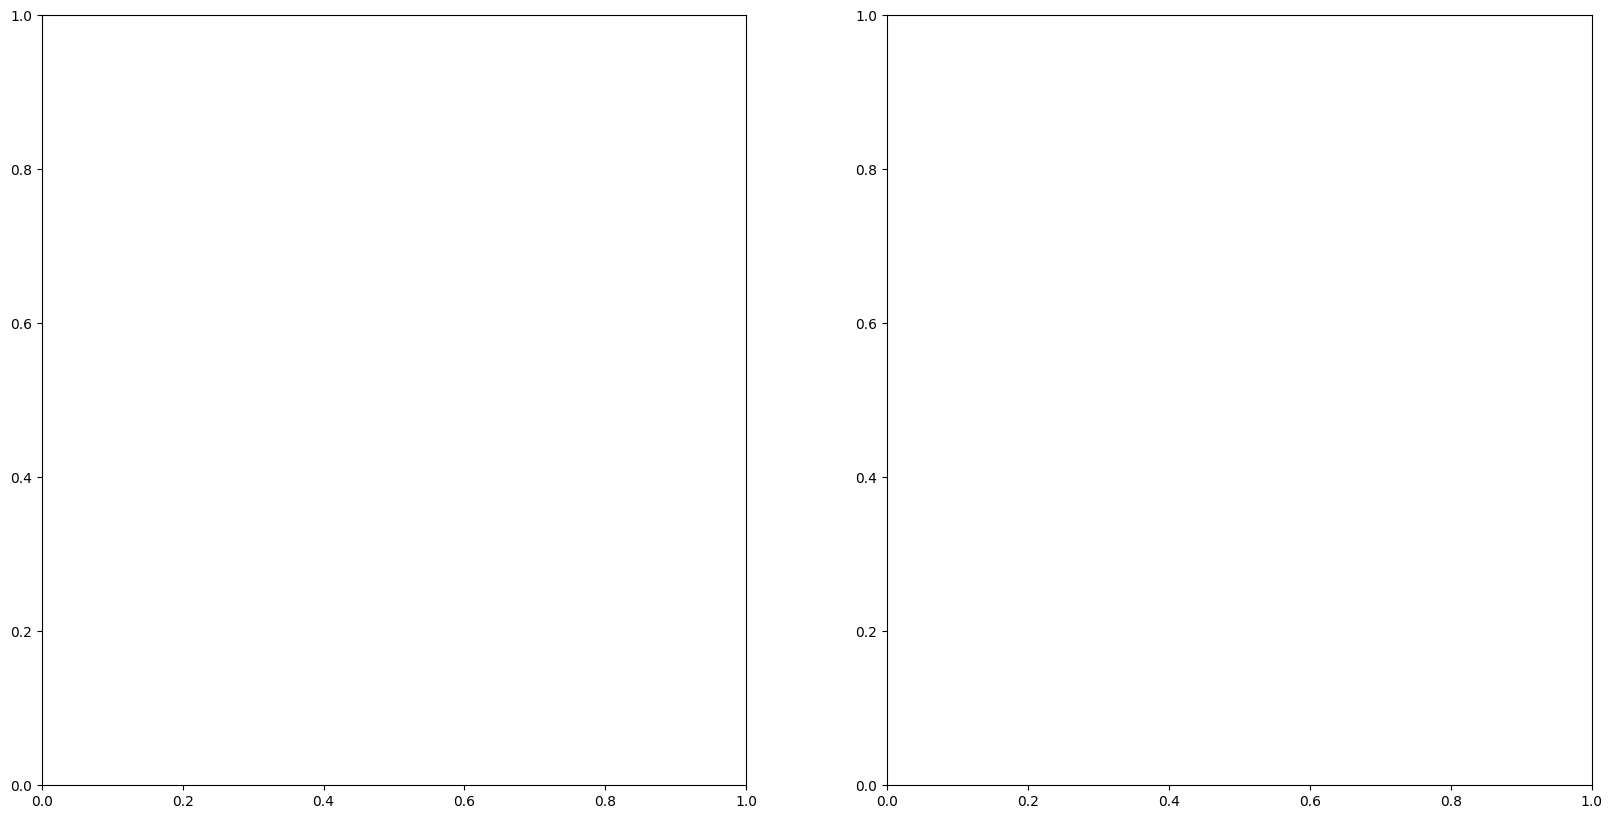

In [98]:
plt.rcParams['figure.figsize'] = (20, 10)
_, axes = plt.subplots(1, 2)
axes = np.array(axes).reshape(-1)
axes[0].imshow(imgs[515])
axes[1].imshow(sampling_masks[515])

In [7]:
print(masks.shape)

(300, 1080, 1920, 3)
